In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import seaborn as sns 

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

import pathlib

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd gdrive/MyDrive

/content/gdrive/MyDrive


In [4]:
stock_df = pd.read_csv("stock_sentiment.csv")
stock_df

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,0
5787,"#Gold prices slip below Rs 46,000 as #investor...",0
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


In [16]:
nltk.download("stopwords")
import string
string.punctuation
stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
def clean_text(message):
    remove_punc = [char for char in message if char not in string.punctuation]
    remove_punc = ''.join(remove_punc)
    #remove_punc = remove_punc.lower()

    return remove_punc

In [9]:
stock_df["no punc"] = stock_df["Text"].apply(clean_text)

In [10]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['http', 'https', 'from', 'subject', 're', 'edu', 'use','will','aap','co','day','user','stock','today','week','year'])

from google.colab import files
#import json



#with open('stop_words.json', 'w') as fp:
 # json.dump(stop_words, fp)

In [11]:
def preprocess(text):
    result = []
    test1 = gensim.utils.simple_preprocess(text)
    test2 = text.split()
    for token in gensim.utils.simple_preprocess(text):
        if len(token) >= 3 and token not in stop_words:
            result.append(token)
                
    return result
    

In [13]:
stock_df['cleaned'] = stock_df['no punc'].apply(preprocess)

In [14]:
stock_df['cleaned'] = stock_df['cleaned'].apply(lambda x: " ".join(x)) 

In [22]:
tweets_length = [ len(x.split()) for x in stock_df['cleaned'] ]
max_length = max(tweets_length)

20


In [24]:
def build_word_dict(texts):
    dit = {'__PAD__': 0, '__UNK__': 1} 
    for sentence in texts: 
        for word in sentence.split():
            if word not in dit: 
                dit[word] = len(dit)
    return dit    

In [26]:
word_dict = build_word_dict(stock_df['cleaned'])
# wordDictJson = []
# for word in word_dict:
#     tmp = {}
#     tmp["word"] = word
#     tmp["code"] = word_dict[word]
#     wordDictJson.append(tmp)

# print(wordDictJson)
print(word_dict)
len(word_dict)

{'__PAD__': 0, '__UNK__': 1, 'kickers': 2, 'watchlist': 3, 'xide': 4, 'tit': 5, 'soq': 6, 'pnk': 7, 'cpw': 8, 'bpz': 9, 'trade': 10, 'method': 11, 'see': 12, 'prev': 13, 'posts': 14, 'movie': 15, 'return': 16, 'feageed': 17, 'indicator': 18, 'trades': 19, 'awesome': 20, 'afraid': 21, 'short': 22, 'amzn': 23, 'looking': 24, 'like': 25, 'nearmonopoly': 26, 'ebooks': 27, 'mnta': 28, 'pgnx': 29, 'current': 30, 'downtrend': 31, 'break': 32, 'otherwise': 33, 'shortterm': 34, 'correction': 35, 'medterm': 36, 'mondays': 37, 'relative': 38, 'weakness': 39, 'nyx': 40, 'win': 41, 'tie': 42, 'tap': 43, 'ice': 44, 'int': 45, 'bmc': 46, 'aon': 47, 'chk': 48, 'biib': 49, 'goog': 50, 'ower': 51, 'trend': 52, 'line': 53, 'channel': 54, 'test': 55, 'volume': 56, 'support': 57, 'watch': 58, 'tomorrow': 59, 'ong': 60, 'entry': 61, 'assuming': 62, 'fcx': 63, 'opens': 64, 'trigger': 65, 'buy': 66, 'still': 67, 'much': 68, 'setup': 69, 'really': 70, 'worries': 71, 'everyone': 72, 'expects': 73, 'market': 74,

9270

In [ ]:
#from google.colab import files
#import json


# print(wordDictJson)
#with open('word_dict.json', 'w') as fp:
 # json.dump(word_dict, fp)

In [28]:
x_train, x_test, y_train, y_test = train_test_split(stock_df['cleaned'], stock_df['Sentiment'], test_size = 0.15)

In [29]:
word_dict_train = build_word_dict(x_train)
print(len(word_dict_train))
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

8438


In [30]:
def sentence_to_vector(sentences, vocab_dict, max_length, unk_token='__UNK__'):
    
    sequences = []
    unk_ID = vocab_dict[unk_token]
    for sentence in sentences:
        word_l = nltk.word_tokenize(sentence)
        vector_word = []
        for word in word_l:
            word_ID = vocab_dict.get(word, unk_ID)
            vector_word.append(word_ID)
        vector_word.extend([0] * (max_length - len(vector_word)))
        sequences.append(vector_word)
    return sequences

In [31]:
train_sequences = np.array(sentence_to_vector(x_train, word_dict_train, max_length))

In [32]:
test_sequences = np.array(sentence_to_vector(x_test, word_dict_train, max_length))

In [34]:
test_model = Sequential()
test_model.add(Embedding(len(word_dict_train), output_dim = 256))
test_model.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu'))
test_model.add(GlobalMaxPool1D())
test_model.add(Dense(64, activation = 'relu'))
test_model.add(Dropout(0.3))
test_model.add(Dense(2,activation = 'softmax'))
test_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
test_model.summary()
test_model.fit(train_sequences, y_train_cat, batch_size = 32, validation_split = 0.15, epochs = 4)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 256)         2160128   
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         98432     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                      

In [35]:
model = Sequential()
model.add(Embedding(len(word_dict), output_dim = 256))
model.add(Conv1D(filters=128, kernel_size=4, padding='valid', activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(2,activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 256)         2373120   
                                                                 
 conv1d_2 (Conv1D)           (None, None, 128)         131200    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                      

In [36]:
sequences = np.array(sentence_to_vector(stock_df['cleaned'], word_dict, max_length))
y = to_categorical(stock_df["Sentiment"], 2)
model.fit(sequences, y, batch_size = 64, validation_split = 0.15, epochs = 4)

Epoch 1/4
77/77 [==============================] - 8s 91ms/step - loss: 0.5863 - acc: 0.6934 - val_loss: 0.7284 - val_acc: 0.5063
Epoch 2/4
77/77 [==============================] - 7s 97ms/step - loss: 0.3192 - acc: 0.8663 - val_loss: 0.7368 - val_acc: 0.5961
Epoch 3/4
77/77 [==============================] - 7s 92ms/step - loss: 0.1202 - acc: 0.9575 - val_loss: 0.9909 - val_acc: 0.5834
Epoch 4/4
77/77 [==============================] - 7s 87ms/step - loss: 0.0484 - acc: 0.9852 - val_loss: 1.2024 - val_acc: 0.5742


In [75]:
pred = test_model.predict(test_sequences)
max_indices = np.argmax(pred, axis = 1)
accuracy = sum(max_indices == y_test)/len(y_test)

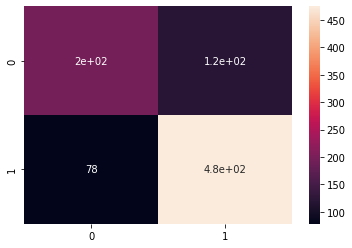

In [76]:
cm = confusion_matrix(y_test, max_indices)
sns.heatmap(cm, annot = True)

In [77]:
test_string = "SpaceX chief engineer quit"
seq = np.array(sentence_to_vector([test_string], word_dict, max_length))
prob = model.predict(seq)
prob

array([[0.98524195, 0.01475809]], dtype=float32)

In [49]:
run_model = tf.function(lambda x: model(x))
concrete_func = run_model.get_concrete_function(tf.TensorSpec([1, max_length], model.inputs[0].dtype))


In [50]:
save_dir = "saved_model"
model.save(save_dir, save_format="tf", signatures=concrete_func)
loaded = tf.keras.models.load_model(save_dir)
#print(list(loaded.signatures.keys()))
#infer = loaded.signatures["serving_default"]
#print(infer.structured_input_signature)
#print(infer.structured_outputs)

INFO:tensorflow:Assets written to: saved_model/assets


In [51]:
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
tflite_model = converter.convert()


In [52]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

10054088

In [53]:
expected = model.predict(sequences)

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
for i in range(len(sequences)):
  interpreter.set_tensor(input_details[0]["index"], sequences[i:i+1].astype(np.float32))
  interpreter.invoke()
  res = interpreter.get_tensor(output_details[0]["index"])
  res = res.flatten()
  np.testing.assert_almost_equal(expected[i], res, decimal=4)